In [1]:
import os
import numpy as np
import astropy.io.fits as pyfits
from scipy.ndimage import gaussian_filter
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Path to training data *** do not change *** 训练数据地址
# DATA_DIR = "/bohr/train-t3g1/v1"
DATA_DIR = ""

DEVICE = "cuda"
MODEL_SAVE_PATH = "model.pth"

BATCH_SIZE = 4
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
SMOOTHING = 3 # parameter for Gaussian Smoothing 高斯平滑参数

# Example Data Usage 数据使用样例

The convergence maps are saved as .fits files in /map folder. The labels are saves as .fits files in /cat folder.

汇聚图再map文件夹下，数据标注在cat文件夹下。

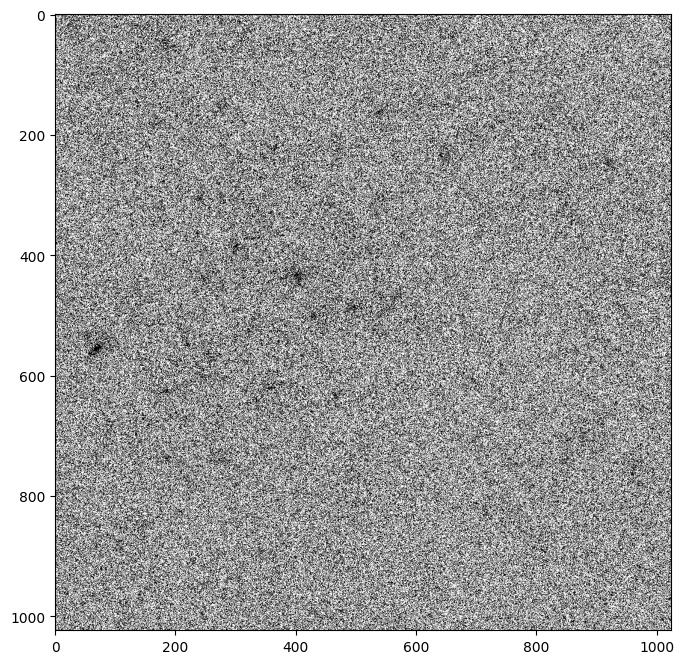

In [3]:
# Show raw convergence map 可视化未处理汇聚图
Z = pyfits.open(os.path.join(DATA_DIR, 'map/1.fits'))[0].data
plt.figure(figsize=(10, 8))
plt.imshow(Z, vmin=-0.1, vmax=0.2, cmap='binary')
plt.show()

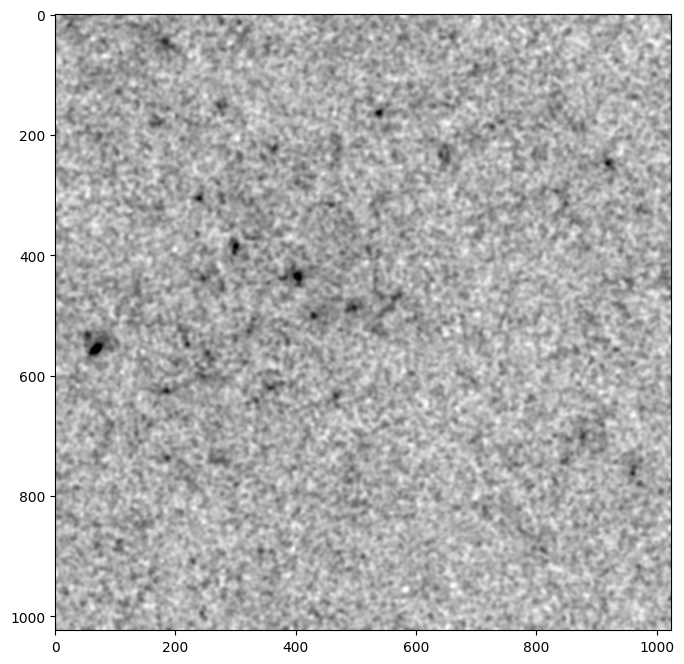

In [4]:
# Apply Gaussian Smoothing 高斯平滑
Z_smooth = gaussian_filter(Z, sigma=SMOOTHING)
plt.figure(figsize=(10, 8))
plt.imshow(Z_smooth, vmin=-0.1, vmax=0.2, cmap='binary')
plt.show()

In [5]:
# Read halo labels 读入暗物质晕标记
cat1 = pyfits.open(os.path.join(DATA_DIR, 'cat/1.fits'))[0].data
print(cat1.shape)

(125, 3)


cat1 is an ndarray containing 125 rows and 3 columns. Each row represents a labeled halo. The first column is the mass of the halo (irrelevant to this problem), the second and third columns are the y-coordinate and x-coordinate of the halo, respectively, in pixels.

cat1是一个125行3列的ndarray，其中每一行描述一个暗物质晕。第一列表示暗物质晕的质量（与本题无关），第二列和第三列为暗物质晕在图中的纵坐标和横坐标。

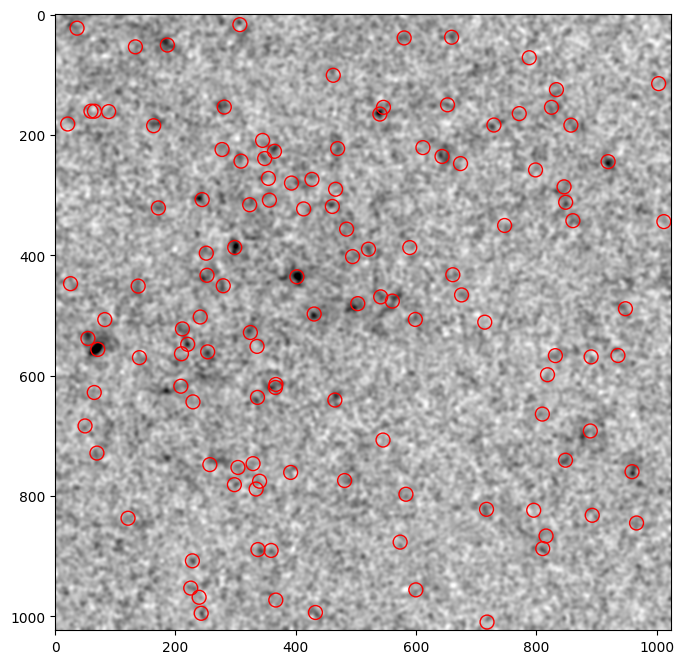

In [6]:
# Visualize halos 可视化暗物质晕
cat1_data = np.transpose(cat1)
plt.figure(figsize=(10, 8))
plt.imshow(Z_smooth, vmin=-0.1, vmax=0.2, cmap='binary')
plt.scatter(cat1_data[2], cat1_data[1], facecolors='none', edgecolors='red',s=100)
plt.show()

# Prepare Dataset and Data Loader 定义数据集

A sample dataset for loading the data is provided. You may modify this according to your needs.

这里提供一个简单的数据预处理写法，选手可以在此基础上加入需要的数据预处理

In [7]:
class AstroDataset(Dataset):
    def __init__(self, map_paths, cat_paths=None):
        self.map_paths = map_paths
        self.cat_paths = cat_paths
    
    def __len__(self):
        return len(self.map_paths)
    
    def __getitem__(self, idx):
        # Load image with gaussian smoothing
        map_data = gaussian_filter(pyfits.open(self.map_paths[idx])[0].data, sigma=SMOOTHING)
        
        if self.cat_paths is None:
            return torch.FloatTensor(map_data).unsqueeze(0)

        # Load catalog
        cat = pyfits.open(self.cat_paths[idx])[0].data
        target = np.zeros((1024, 1024))

        for y, x in cat[:, 1:3]:
            target[int(y), int(x)] = 1.0

        return torch.FloatTensor(map_data).unsqueeze(0), torch.FloatTensor(target), self.cat_paths[idx]


In [8]:
data_size = len(os.listdir(os.path.join(DATA_DIR, 'map')))

# Ensure correct data and label ordering
dataset = AstroDataset([os.path.join(DATA_DIR, f'map/{i}.fits') for i in range(1, data_size+1)], 
                       [os.path.join(DATA_DIR, f'cat/{i}.fits') for i in range(1, data_size+1)])

# Create data loader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define and Train Model 模型定义与训练

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=15, padding=7),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7, padding=3),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=1),
            # nn.Conv2d(64, 1, kernel_size=1),
            # nn.BatchNorm2d(1),
            nn.Conv2d(32, 1, kernel_size=1),
            # nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.net(x)

In [10]:
# Function for applicating model results 读取模型输出
def detect_objects(model, image_path, confidence_threshold, device=DEVICE):
    model.eval()
    with torch.no_grad():
        # Load and preprocess image
        map_data = gaussian_filter(pyfits.open(image_path)[0].data, sigma=SMOOTHING)
        image = torch.FloatTensor(map_data).unsqueeze(0).unsqueeze(0).to(device)
        
        # Get predictions
        output = model(image)
        predictions = output.cpu().squeeze().numpy()
        
        # Convert to coordinates
        coordinates = []
        for y, x in zip(*np.where(predictions > confidence_threshold)):
            confidence = predictions[y, x]
            coordinates.append((x, y, confidence))
            
        return coordinates

# Visualizing model predictions 可视化模型输出
def visualize_results(model, image_path, label_path, confidence_threshold, device=DEVICE):
    # Get predictions with confidence scores
    results = detect_objects(model, image_path, confidence_threshold, device)
    results = np.array(results).T if results else np.array([[],[],[]])
    
    Z = pyfits.open(image_path)[0].data
    Z_smooth = gaussian_filter(Z, sigma=SMOOTHING)
    
    labels = np.transpose(pyfits.open(label_path)[0].data)
    
    plt.figure(figsize=(10,10))
    plt.imshow(Z_smooth, vmin=-0.1, vmax=0.2, cmap='binary')
    plt.scatter(labels[2], labels[1], facecolors='none', edgecolors='red', s=100, label="True")
    if len(results[0]) > 0:
        # Color the scatter points based on confidence scores
        plt.scatter(results[0], results[1], facecolors='none', edgecolors='green', s=100, label="Predicted")
    plt.legend()
    plt.show()


'''
Metric function for calculating PR-AUC.
This exact function will be used for evaluation
计算PR-AUC分数
此原函数将用于比赛评测
'''
def calculate_precision_recall_curve(predictions, labels):

    print("shape of predictions: ", predictions.shape)

    # Flatten the predictions and get the indices of the sorted predictions
    flat_predictions = predictions.flatten()
    sorted_indices = np.argsort(-flat_predictions)  # Sort in descending order

    precisions = []
    recalls = []

    true_preds = 0
    num_preds = 0
    predicted_labels = 0
    num_labels = sum(len(l) for l in labels)

    labels_within_distance = [[] for _ in range(len(flat_predictions))]

    i = 0
    for image_idx, image_labels in enumerate(labels):
        for y_true, x_true in image_labels:
            for y in range(max(0, int(y_true) - 15), min(1024, int(y_true) + 16)):
                # Calculate the maximum x distance for the current y
                max_x_dist = int((max(0, 15**2 - (y - y_true)**2))**0.5)
                # Calculate the range of x-coordinates
                for x in range(max(0, int(x_true) - max_x_dist), min(1024, int(x_true) + max_x_dist + 1)):
                    coord_idx = image_idx * 1024 * 1024 + y * 1024 + x
                    labels_within_distance[coord_idx].append(i)
            i += 1
    
    label_predicted = [False] * num_labels

    # Iterate over sorted predictions
    for idx in sorted_indices:

        num_preds += 1

        # Determine the image index and the coordinate within the image
        image_idx = idx // (1024 * 1024)
        coord_idx = idx % (1024 * 1024)
        y, x = divmod(coord_idx, 1024)

        if len(labels_within_distance[idx]) > 0:
            true_preds += 1
            for label in labels_within_distance[idx]:
                if label_predicted[label] is False:
                    label_predicted[label] = True
                    predicted_labels += 1

        # Calculate precision and recall
        precision = true_preds / num_preds
        recall = predicted_labels / num_labels

        # Append precision and recall to the lists
        precisions.append(precision)
        recalls.append(recall)

    # Calculate PR-AUC using the trapezoidal rule
    pr_auc = np.trapz(precisions, x=recalls)

    return precisions, recalls, pr_auc

# Evaluate model 评测模型
def get_pr(model, test_loader, device=DEVICE):
    model.eval()
    for images, _, paths in test_loader:
        with torch.no_grad():
            images = images.to(device)
            outputs = model(images).cpu().numpy().squeeze(1)
            cat_data = [np.transpose(pyfits.open(path)[0].data) for path in paths]
            labels = [list(zip(cat[1], cat[2])) for cat in cat_data]
        return calculate_precision_recall_curve(outputs, labels)

In [11]:
# Model instance training 模型训练

model = Model().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    
    for images, targets, _ in dataloader:
        images = images.to(DEVICE)
        targets = targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    train_loss = total_loss/len(dataloader)
    train_losses.append(train_loss)
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Training Loss: {train_loss:.8f}')

Epoch [1/50], Training Loss: 0.33729869
Epoch [2/50], Training Loss: 0.00283509
Epoch [3/50], Training Loss: 0.00369526
Epoch [4/50], Training Loss: 0.00374764
Epoch [5/50], Training Loss: 0.00298879
Epoch [6/50], Training Loss: 0.00168259
Epoch [7/50], Training Loss: 0.00118540
Epoch [8/50], Training Loss: 0.00111291
Epoch [9/50], Training Loss: 0.00109264
Epoch [10/50], Training Loss: 0.00108151
Epoch [11/50], Training Loss: 0.00107026
Epoch [12/50], Training Loss: 0.00106361
Epoch [13/50], Training Loss: 0.00105691
Epoch [14/50], Training Loss: 0.00105527
Epoch [15/50], Training Loss: 0.00104606
Epoch [16/50], Training Loss: 0.00104139
Epoch [17/50], Training Loss: 0.00103898
Epoch [18/50], Training Loss: 0.00103360
Epoch [19/50], Training Loss: 0.00103217
Epoch [20/50], Training Loss: 0.00103116
Epoch [21/50], Training Loss: 0.00103205
Epoch [22/50], Training Loss: 0.00102736
Epoch [23/50], Training Loss: 0.00102320
Epoch [24/50], Training Loss: 0.00102334
Epoch [25/50], Training L

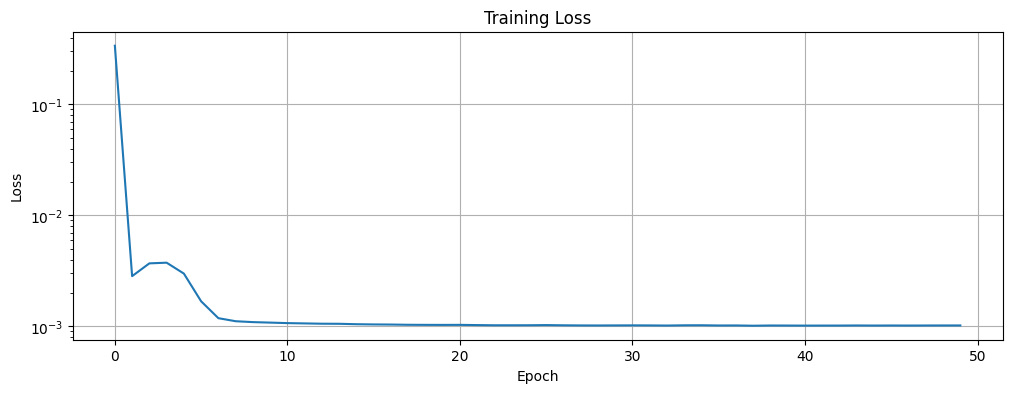

In [12]:
# Plot training curve 训练过程可视化
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss')
plt.grid(True)

plt.show()

# Inference and Testing 模型测试

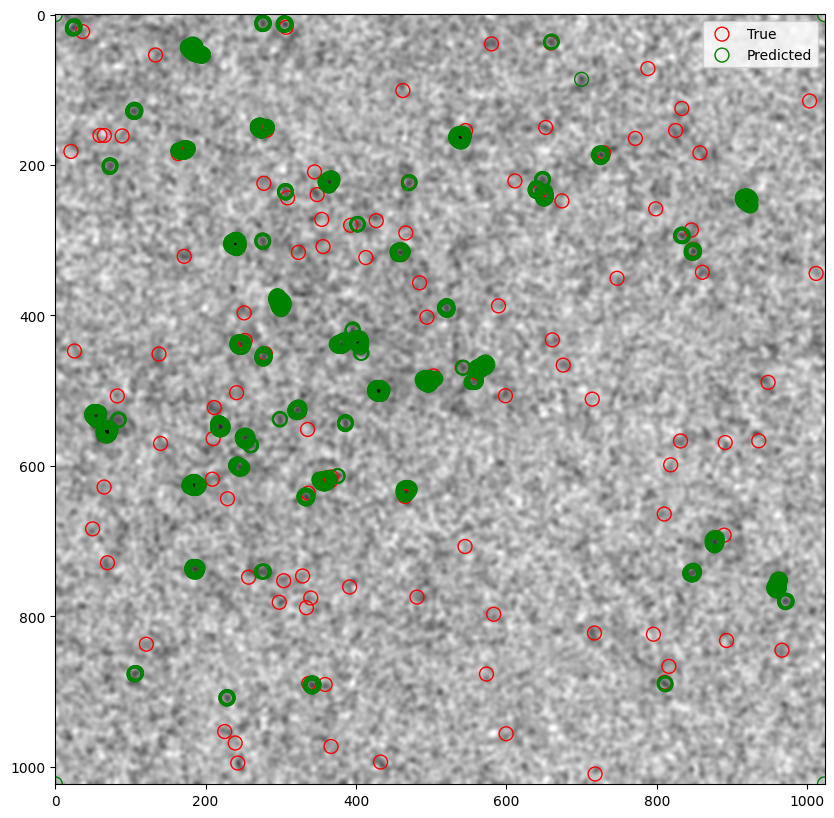

In [13]:
visualize_results(model, dataset.map_paths[0], dataset.cat_paths[0], confidence_threshold=0.005)

shape of predictions:  (4, 1024, 1024)
PR-AUC Score: 0.5645


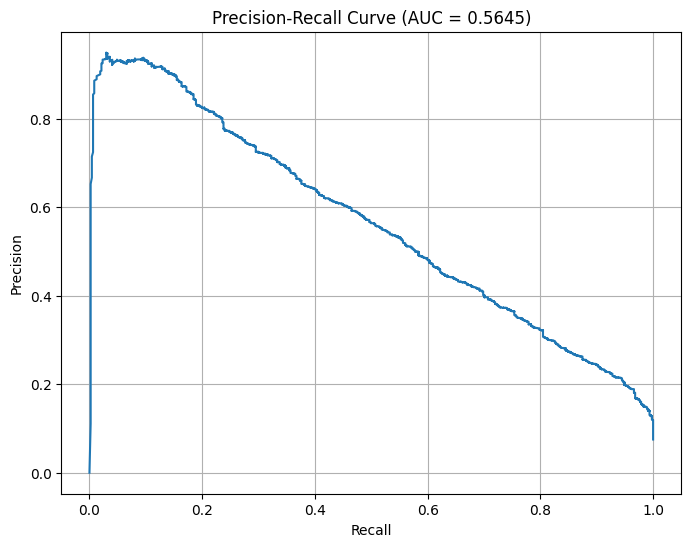

In [14]:
# Calculate PR-AUC 计算PR-AUC分数
precisions, recalls, pr_auc = get_pr(model, dataloader)
print(f"PR-AUC Score: {pr_auc:.4f}")

# Plot PR curve 可视化精确率-召回率曲线
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.grid(True)
plt.show()

# Submission 提交结果
In your submitted code, the environment variable ```DATA_PATH``` will be assigned a value to the testing dataset. This dataset is inaccessible by contestants. You can modify this code based on how your model inferencing works, but do not change the shape or format of the submitted files. While the full training code is provided in the baseline, you should only submit the inference section of your code. You should submit your best model parameters by creating a dataset on Bohrium including your model weights, and attaching the dataset to your submission. Your inference code should read your model weights from the dataset (from the /bohr path) and read test data from the DATA_PATH environment variable. The following submission code is for your reference. **See the problem description for more details on submission.**

IMPORTANT: You are required to keep the full source code (.ipynb) that resulted in your best model. The competition committee reserves the right to cancel your scores if you fail to provide code that reproduces your best model when requested. You are encouraged to employ practices such as setting constant random seeds to ensure reproducibility.

在提交的代码中，环境变量```DATA_PATH```将被赋值为测试数据路径。测试数据对选手不可见。你可以根据你的模型推理方式修改这段代码，但不要改变输出文件的形状与格式。此Baseline包括了模型从零训练的全部代码，但在比赛正式提交时你只需要提交模型预测部分代码。你需要将你的模型参数以数据集的形式提交到Bohrium。你的预测代码可以直接通过数据集的/bohr路径读取模型参数，并从环境变量```DATA_PATH```中读取测试数据。以下代码为参考。**在题目描述中有更详细的提交要求，请选手仔细阅读。**

注意：请选手妥善保留自己的源代码。如果选手无法提供能够复现提交的最优模型的源代码，将无法参与奖项评选。选手应考虑使用确定的随机种子等以保证代码运行结果可被复现。

In [15]:
import zipfile

if os.environ.get('DATA_PATH'):
    # Submit testA for public leaderboard 提交选手公开傍结果
    DATA_PATH = os.environ.get('DATA_PATH') + "/"
    TEST_DATA_DIR = DATA_PATH + 'halo_testA'
    test_size = len(os.listdir(os.path.join(TEST_DATA_DIR, 'map')))
    dataset = AstroDataset([os.path.join(TEST_DATA_DIR, f'map/{i}.fits') for i in range(1, test_size+1)])
    loader = DataLoader(dataset, batch_size=test_size, shuffle=False)
    model.eval()
    for images in loader:
        with torch.no_grad():
            outputs = model(images.to(DEVICE)).cpu().numpy().squeeze(1)
        np.save('submissionsA.npy', outputs)
    # Submit testB for private leaderboard 提交评测数据结果
    TEST_DATA_DIR = DATA_PATH + 'halo_testB'
    test_size = len(os.listdir(os.path.join(TEST_DATA_DIR, 'map')))
    dataset = AstroDataset([os.path.join(TEST_DATA_DIR, f'map/{i}.fits') for i in range(1, test_size+1)])
    loader = DataLoader(dataset, batch_size=test_size, shuffle=False)
    model.eval()
    for images in loader:
        with torch.no_grad():
            outputs = model(images.to(DEVICE)).cpu().numpy().squeeze(1)
        np.save('submissionsB.npy', outputs)
    
    # The final submission will be a zip file containing the your model outputs for both testing sets
    # 最终提交一个压缩文件包括两个npy文件。
    with zipfile.ZipFile('submission.zip', 'w') as zipf:
        zipf.write('submissionsA.npy')
        zipf.write('submissionsB.npy')

In [16]:
torch.save(model, f"model{pr_auc:.4f}.pth")